In [1]:
# change directory
import os
rootdir = os.path.dirname(os.getcwd())
os.chdir(rootdir)

# import third libs for data
import datetime as dt
import numpy as np
import pandas as pd

# make imports
from utils import rendering as vw
from benchmarks import schema as sch
from config import DATA_DIR

In [2]:
benchmarkid = 'Dialysis2021'
dbmsid = 'MySql'

In [3]:
ganttview = vw.GanttView(benchmarkid, dbmsid)
ganttview

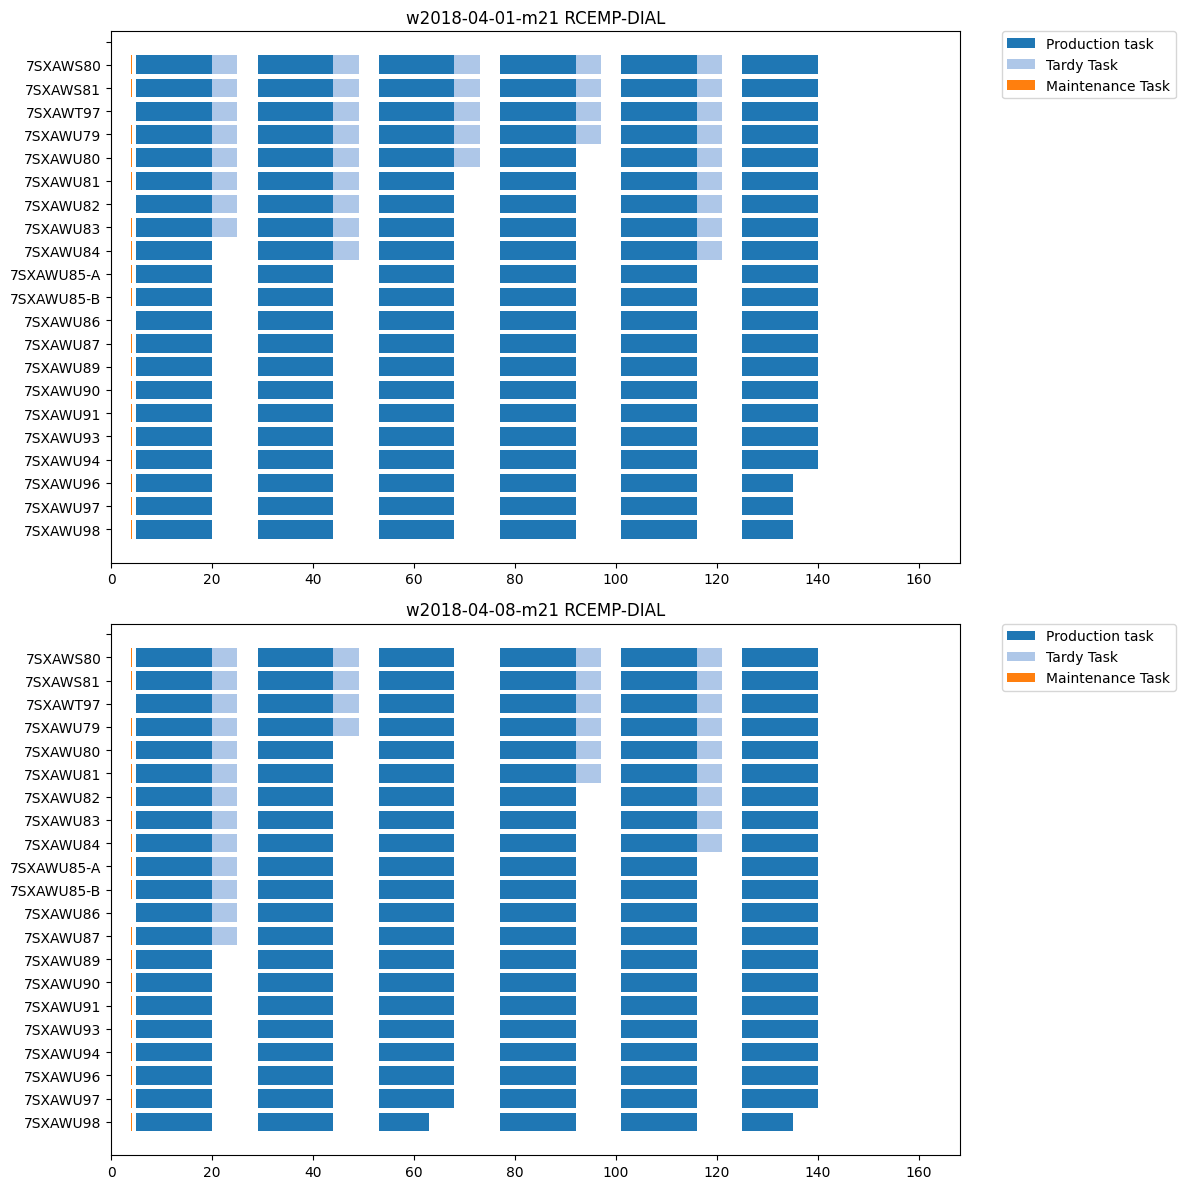

In [4]:
f = lambda exp: f"{exp['problem_name']} {exp['model_name']}"
ganttview.plot('%21', '%CEMP%', time_window=(0, 168), title_format=f)

In [5]:
# f = lambda exp: f"{exp['problem_name'][:-2].replace('_', '-')} ({exp['model_name'][:-5]})"
# f = lambda exp: '(a)' if exp['model_name'][:-5] == 'SCEMP' else '(b)'
# ganttview.plot('k1_20_3', '%CEMP%', title_format=f, time_window=(0, 1200), saveas='gantt_comparison.png')

In [6]:
# prod_var_names = ['Cmax', 'R', 'nR']
# statsview = vw.StatsView(benchmarkid, dbmsid)
# statsview.compare('RCEMPModel', 'SCEMPModel', prod_var_names, 
#                   instance_pattern='(\S+)_\d+', by_method=True,
#                   save_as='prod_performances.csv')

In [7]:
# maint_var_names = ['nTM', 'Abar']
# statsview.compare('RCEMPModel', 'SCEMPModel', maint_var_names, 
#                   instance_pattern='(\S+)_\d+', by_method=True,
#                   save_as='maint_performances.csv')

In [8]:
# exec_var_names = ['nC', 'Es']
# statsview.compare('RCEMPModel', 'SCEMPModel', exec_var_names, 
#                   instance_pattern='(\S+)_\d+', by_method=True,
#                   save_as='exec_performances.csv')

In [9]:
# var_names = prod_var_names + maint_var_names + exec_var_names
# statsview.test(var_names, problem_filter='%', save_as='test_performances.csv')

## identification des periodes

In [10]:
benchmarkname = 'HGD_dialysis_2018_2021'
benchmarkdir = os.path.join(DATA_DIR, 'raw', benchmarkname)
patients_path = os.path.join(benchmarkdir, 'echantillons_patients.csv')
patients_sample = pd.read_csv(patients_path)
patients_sample.head()

,Date,number,day,release_date,due_date,duration,period,instance
0,2018-03-26,14,1,5,20,5,2018-04-01,w2018-04-01-m4
1,2018-03-27,14,2,5,20,5,2018-04-01,w2018-04-01-m4
2,2018-03-28,13,3,5,20,5,2018-04-01,w2018-04-01-m4
3,2018-03-29,13,4,5,20,5,2018-04-01,w2018-04-01-m4
4,2018-03-30,14,5,5,20,5,2018-04-01,w2018-04-01-m4


In [11]:
patients_sample.dtypes

Date            object
number           int64
day              int64
release_date     int64
due_date         int64
duration         int64
period          object
instance        object
dtype: object

In [12]:
periods = patients_sample['period']
periods = list(set(v for v in periods.to_dict().values()))
periods

['2018-04-01', '2018-04-08']

## Calcul des retards reels

In [13]:
datapath = os.path.join(benchmarkdir, 'donnees_seances.csv')
seances = pd.read_csv(datapath, sep=';', index_col='Date', parse_dates=True, dayfirst=True)
seances.head()

,ID,Tour,Patients,Debut,Duree
Date,,,,,
2018-03-26,1,Tour1,21,5,5
2018-03-26,2,Tour2,21,10,5
2018-03-26,3,Tour3,21,15,5
2018-03-26,4,Tour4,8,20,5
2018-03-27,5,Tour1,21,5,5


In [36]:
retards = seances[seances.Tour == 'Tour4']
retards.head()

,ID,Tour,Patients,Debut,Duree
Date,,,,,
2018-03-26,4,Tour4,8,20,5
2018-03-27,8,Tour4,9,20,5
2018-03-28,12,Tour4,5,20,5
2018-03-29,16,Tour4,4,20,5
2018-03-30,20,Tour4,9,20,5


In [37]:
nR = retards['Patients']
R = retards['Patients'] * retards['Duree']
R.name, nR.name = 'R', 'nR'
R, nR = R.astype(int), nR.astype(int)
real_stats = pd.concat([R, nR], axis=1)
real_stats.head()

,R,nR
Date,,
2018-03-26,40,8
2018-03-27,45,9
2018-03-28,25,5
2018-03-29,20,4
2018-03-30,45,9


In [38]:
real_stats_hebdo = real_stats.resample('W').sum()
real_stats_hebdo.reset_index(inplace=True)
real_stats_hebdo = real_stats_hebdo[real_stats_hebdo['Date'].isin(periods)]
real_stats_hebdo.head()

,Date,R,nR
0,2018-04-01,175,35
1,2018-04-08,160,32


In [39]:
real_stats_hebdo['problem'] = real_stats_hebdo['Date'].dt.strftime('w%Y-%m-%d-m21')
real_stats_hebdo.drop(['Date'], axis=1, inplace=True)
real_stats_hebdo.set_index('problem', inplace=True)
real_stats_hebdo.head()

,R,nR
problem,,
w2018-04-01-m21,175,35
w2018-04-08-m21,160,32


In [40]:
real_stats_hebdo.shape

(2, 2)

## Collecte des retards simulees

In [41]:
sql = f"""select p.name as problem_name, s.name as var_name, s.value 
                from statistics s, problems p, experiments e
                where s.exp_id = e.uid and e.problem_id = p.uid
                and e.model_name in ('RCEMP-DIAL')
                and s.name in ('R', 'nR')
                and p.name like '%21'
                order by p.name, s.name, s.value;"""

In [42]:
statsview = vw.StatsView(benchmarkid, dbmsid)
data = statsview.load_results(sql)
data.head()

,problem_name,var_name,value
0,w2018-04-01-m21,nR,35.0
1,w2018-04-01-m21,R,175.0
2,w2018-04-08-m21,nR,32.0
3,w2018-04-08-m21,R,160.0


In [43]:
sim_vars = []
indexed_data = data.set_index('problem_name')
for var_name, var_data in indexed_data.groupby('var_name'):
    var = var_data['value']
    var.name = var_name
    sim_vars.append(var)
sim_data_hebdo = pd.concat(sim_vars, axis=1)
sim_data_hebdo.head()

,R,nR
problem_name,,
w2018-04-01-m21,175.0,35.0
w2018-04-08-m21,160.0,32.0


## Comparaison des retards

In [44]:
compared_data = real_stats_hebdo.merge(sim_data_hebdo, left_index=True, right_index=True, suffixes=('_real', '_sim'))
compared_data['delta_R'] = ((compared_data['R_sim']/compared_data['R_real']) - 1) * 100
compared_data['delta_nR'] = ((compared_data['nR_sim']/compared_data['nR_real']) - 1) * 100
compared_data.head(25)

,R_real,nR_real,R_sim,nR_sim,delta_R,delta_nR
problem,,,,,,
w2018-04-01-m21,175,35,175.0,35.0,0.0,0.0
w2018-04-08-m21,160,32,160.0,32.0,0.0,0.0


In [45]:
15/60

0.25

In [46]:
2*7*24

336

In [47]:
law = {'name':'norm', 'params':{'loc':336, 'scale':12}}
device = sch.Device(use_duration=509, law=law)
phm = sch.PHMModule()
phm.rul(device, next=False)

1.0

## Collecte des disponibilites simulees

In [48]:
sql = f"""select p.name as problem_name, s.name as var_name, s.value 
                from statistics s, problems p, experiments e
                where s.exp_id = e.uid and e.problem_id = p.uid
                and e.model_name in ('RCEMP-DIAL')
                and s.name = 'Abar'
                and p.name like '%21'
                order by p.name, s.name, s.value;"""

In [49]:
statsview = vw.StatsView(benchmarkid, dbmsid)
data = statsview.load_results(sql)
data.head(100)

,problem_name,var_name,value
0,w2018-04-01-m21,Abar,1.0
1,w2018-04-08-m21,Abar,1.0
